In [304]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

In [4]:
def earth_model(rock_props):
    """Builds a earth model using input Vp-Density pairs and calculates reflection coefficients and layer impedance.

    Parameters
    ----------
    rock_props : list
        A list of len 6 containing Vp-Density pairs for the three layers

    Returns
    -------
    rc : ndarray
        Numpy ndarray containing reflection coefficients
    imp : ndarray
        Numpy ndarray containing layer impedance

    """
    # define the earth model
    width, height = 101, 240
    model = 1 + np.tri(height, width, -height // 3, dtype=int)
    model[: height // 3, :] = 0

    # reshape the input rock properties list for populating earth model
    rocks = np.array(rock_props).reshape(3, 2)

    # use fancy indexing to create an earth model where each layer of the model
    # has Vp & Density at each location
    earth = rocks[model]

    # calculate the acoustic impedance of each layer
    imp = np.apply_along_axis(np.product, -1, earth)

    # calculate the reflection coefficients for the interfaces between each layer
    rc = np.zeros(imp.shape, dtype=float)
    rc[1:, :] = (imp[1:, :] - imp[:-1, :]) / (imp[1:, :] + imp[:-1, :])

    return rc, imp

In [5]:
def wavelet(duration=0.100, dt=0.001, w_type=0, f=None):
    """This function defines a wavelet to convolve with the earth model reflection coefficients

    Parameters
    ----------
    duration : float
        length in seconds of wavelet
    dt : float
        sample increment of wavelet
    w_type : int
        Wavelet type. 0 is Ricker, 1 is Ormsby
    f : list
        dominant frequency of wavelet

    Returns
    -------
    ndarray
        wavelet amplitude

    """
    if f is None:
        f = [25]
    t = np.linspace(-duration / 2, (duration - dt) / 2, int(duration / dt))
    if w_type:
        # Ormsby wavelet
        f1, f2, f3, f4 = [x for x in f]
        a = ((np.pi * f4)**2)/((np.pi * f4) - (np.pi * f3))
        b = ((np.pi * f3)**2)/((np.pi * f4) - (np.pi * f3))
        c = ((np.pi * f2)**2)/((np.pi * f2) - (np.pi * f1))
        d = ((np.pi * f1)**2)/((np.pi * f2) - (np.pi * f1))
        w = (((a * (np.sinc(f4 * t))**2) - (b * (np.sinc(f3 * t))**2)) -
             ((c * (np.sinc(f2 * t))**2) - (d * (np.sinc(f1 * t))**2)))
    else:
        # Ricker wavelet
        f = f[0]
        w = (1.0 - 2.0 * (np.pi ** 2) * (f ** 2) * (t ** 2)) * np.exp(
            -(np.pi ** 2) * (f ** 2) * (t ** 2)
        )
    return np.squeeze(w) / np.amax(w)

In [6]:
def tuning_wedge(rc, w):
    """Calculates synthetic tuning wedge based on reflection coefficients and wavelet

    Parameters
    ----------
    rc : ndarray
        ndarray of reflection coefficients
    w : ndarray
        wavelet

    Returns
    -------
    ndarray
        ndarray of synthetic tuning wedge

    """
    synth = np.apply_along_axis(lambda t: np.convolve(t, w, mode="same"), axis=0, arr=rc)
    return synth

In [7]:
rock_props = [3000, 2.5, 2700, 2.3, 3000, 2.5]

In [8]:
rc, imp = earth_model(rock_props)

In [9]:
wvlt = wavelet()

In [10]:
synth = tuning_wedge(rc, wvlt)

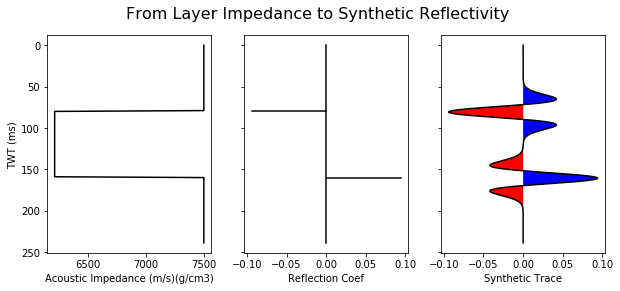

In [89]:
fig, ax = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(10,4))

fig.suptitle('From Layer Impedance to Synthetic Reflectivity', fontsize=16)

y = np.zeros(imp.shape[0])
y[1:] += 0.001
y = np.cumsum(y) * 1000

ax[0].plot(imp[:,80], y, c='k')
ax[0].invert_yaxis()
ax[0].set_xlabel('Acoustic Impedance (m/s)(g/cm3)')
ax[0].set_ylabel('TWT (ms)')

#ax[1].stem(rc[:,80], y, use_line_collection=True)
ax[1].plot(np.zeros(y.shape), y, c='k')
ax[1].plot([np.nanmin(rc[:,80]), 0], [np.argmin(rc[:,80]), np.argmin(rc[:,80])], c='k')
ax[1].plot([0, np.nanmax(rc[:,80])], [np.argmax(rc[:,80]), np.argmax(rc[:,80])], c='k')
ax[1].set_xlabel('Reflection Coef')

ax[2].plot(synth[:,80], y, c='k')
ax[2].fill_betweenx(y, 0, synth[:,80], where=synth[:,80]>=0, facecolor='blue', interpolate=True)
ax[2].fill_betweenx(y, 0, synth[:,80], where=synth[:,80]<=0, facecolor='red')
ax[2].set_xlabel('Synthetic Trace')

plt.savefig('../pyseistuned/static/img/layerAI_rc_synth.png', dpi=300, edgecolor='k')

In [259]:
wt = np.zeros(imp.shape[1])
wt[1:] += 0.001
wt = np.cumsum(wt) * 1000

dx = int(round(((np.max(wt) - np.min(wt))/imp.shape[1])*5))
imp_min = imp.min()
imp_max = imp.max()
imp_diff = imp_max - imp_min

In [260]:
dx

5

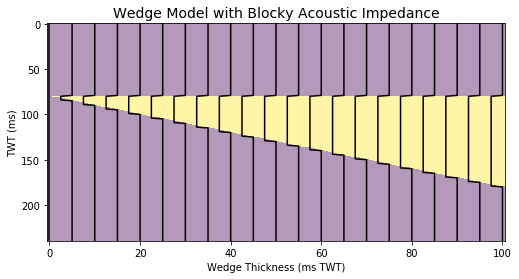

In [261]:
fig = plt.figure(figsize=(10,4))
ax = fig.add_subplot(111)
for i, trace in enumerate(imp.transpose()[::dx, :]):
    tr = (((trace - imp_max)/imp_diff))*dx*0.5
    x = i*dx
    ax.plot((x + tr), y, 'k')
ax.imshow(imp, cmap='viridis_r', alpha=0.4, aspect=0.2)
ax.set_xlabel('Wedge Thickness (ms TWT)')
ax.set_ylabel('TWT (ms)')
ax.set_title('Wedge Model with Blocky Acoustic Impedance', fontsize=14)
#plt.show()
plt.savefig('../pyseistuned/static/img/wedge_model_w_blocky_impedance.png', dpi=300, edgecolor='k')

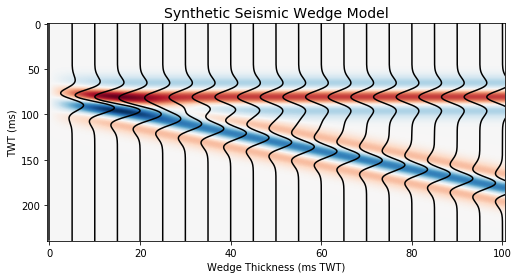

In [265]:
syn_min = synth.min()
syn_max = synth.max()
d_syn = syn_max - syn_min

fig = plt.figure(figsize=(10,4))
ax = fig.add_subplot(111)
for i, trace in enumerate(synth.transpose()[::dx, :]):
    tr = (((trace - syn_min)/d_syn) - 0.5)*2*dx
    x = 0 + i*dx
    ax.plot((x + tr), y, 'k')
ax.imshow(synth, cmap='RdBu', aspect=0.2, interpolation='bilinear')
ax.set_xlabel('Wedge Thickness (ms TWT)')
ax.set_ylabel('TWT (ms)')
ax.set_title('Synthetic Seismic Wedge Model', fontsize=14)
#plt.show()
plt.savefig('../pyseistuned/static/img/synthetic_wedge_model.png', dpi=300, edgecolor='k')

In [288]:
def tuning_curve(synth, rock_props, dt, w_type, f=None):
    """Calculates the tuning curve

    Parameters
    ----------
    synth : ndarray
        array of synthetic seismic values
    rock_props : list
        list of rock properties (Vp, Density)
    dt : float
        wavelet sample increment
    w_type : int
        Wavelet type. 0 for Ricker, 1 for Ormsby
    f : list
        wavelet frequency(ies)

    Returns
    -------
    z : ndarray
        wedge thickness
    z_tuning : float
        tuning thickness in TWT
    amp : ndarray
        extracted amplitude along the top of the wedge model
    z_apparent : ndarray
        apparent wedge thickness
    z_onset : int
        wedge thickness at onset of tuning
    tuning_onset : float
        tuning onset thickness in milliseconds
    tuning : float
        tuning thickness in milliseconds
    resolution_limit : float
        limit of resolution in milliseconds

    """

    # Get central frequency depending on wavelet type, first set default value if not passed in
    if f is None:
        f = [25]
    if w_type:
        # take average of low cut and high cut in Ormsby filter
        f_central = (f[0] + f[3]) / 2
        tuning_onset = 1 / f_central * 1000
        tuning = tuning_onset / 2
        resolution_limit = 1 / f_central / 4 * 1000
    else:
        # Ricker central frequency
        f_central = f[0]
        f_apparent = f_central * np.pi / np.sqrt(6)
        tuning_onset = 1 / f_apparent * 1000
        tuning = tuning_onset / 2
        resolution_limit = 1 / f_apparent / 4 * 1000

    rocks = np.array(rock_props).reshape(3, 2)
    AI = np.apply_along_axis(np.product, -1, rocks)

    # create an ndarray containing index value of top of wedge
    if AI[1] < AI[0]:
        top_idx = np.nanargmin(synth[:, -1])  # use the last column in model to get top at min amplitude
    else:
        top_idx = np.nanargmax(synth[:, -1])  # use the last column in model to get top at max amplitude

    top = np.ones(synth.shape[1], dtype=int) * top_idx

    # calculate the wedge thickness
    z = np.zeros(synth.shape[1])
    z[1:] += dt
    z = np.cumsum(z) * 1000
    z = z.astype(np.int64)  # force wedge thicknesses to be integers

    # determine the thickness at which synth has max amplitude
    # This is the measured tuning thickness in TWT
    z_tuning_idx = np.nanargmax(abs(synth[np.nanmax(top), :]))
    z_tuning_arr = np.zeros(z_tuning_idx + 1)
    z_tuning_arr[1:] += dt
    z_tuning_arr = np.cumsum(z_tuning_arr) * 1000
    z_tuning = z_tuning_arr[-1]

    # determine the apparent thickness at which synth has max amplitude
    # this represents what is seismically resolvable, in TWT
    if AI[1] < AI[0]:
        top_apparent = np.apply_along_axis(np.nanargmin, 0, synth)
        base_apparent = np.apply_along_axis(np.nanargmax, 0, synth)
    else:
        top_apparent = np.apply_along_axis(np.nanargmax, 0, synth)
        base_apparent = np.apply_along_axis(np.nanargmin, 0, synth)

    z_apparent = base_apparent - top_apparent
    z_apparent[0] = z_apparent[1]  # project the minimum apparent thickness to the first index
    z_apparent = z_apparent * dt * 1000
    z_apparent = z_apparent.astype(np.int64)

    # extract the amplitude along the top of the wedge model
    amp = abs(synth[top_idx, :])

    # sometimes if frequency is very low and the sample increment is small, the wedge will not be wide enough to get
    # the tuning onset and will result in an IndexError.  When that happens, return theoretical onset instead.
    try:
        # calculate the tuning onset thickness based on divergence between true and apparent wedge thickness
        z_onset_idx = np.argwhere(z - z_apparent > 0)[-1][0] + 1  # the last value is where thinning causes tuning onset
        z_onset = z_apparent[z_onset_idx]
    except IndexError:
        if w_type:
            z_onset = int((1 / f_central) * 1000)
        else:
            z_onset = int((1 / (np.pi / np.sqrt(6) * f_central)) * 1000)

    return z, z_tuning, amp, z_apparent, z_onset, tuning_onset, tuning, resolution_limit

In [289]:
wedge_thickness, tuning_twt_meas, amp, apparent_wedge_thickness, tuning_twt_onset_meas, tuning_twt_onset, tuning_twt, res_limit = tuning_curve(synth, rock_props, 0.001, 0, f=[25])

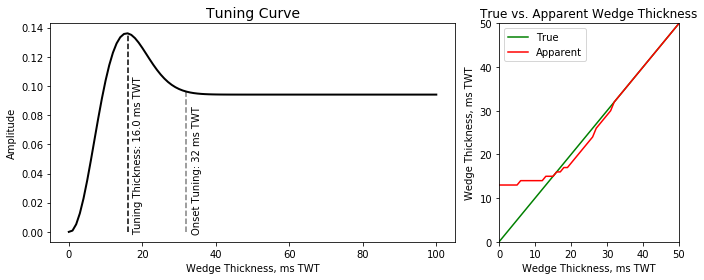

In [334]:
fig = plt.figure(figsize=(10,4))

grid = GridSpec(1, 3, figure=fig)

ax1 = fig.add_subplot(grid[0, :-1])
ax1.plot(wedge_thickness, amp, 'k', linewidth=2)
ax1.vlines(tuning_twt_meas, 0, np.max(amp), linestyles='dashed')
tuning_thickness_string = 'Tuning Thickness: {} ms TWT'.format(round(tuning_twt_meas))
ax1.annotate(tuning_thickness_string, (tuning_twt_meas+1.5, 0), rotation=90)
ax1.vlines(tuning_twt_onset_meas, 0, amp[tuning_twt_onset_meas], linestyle='dashed', colors='grey')
onset_thickness_string = 'Onset Tuning: {} ms TWT'.format(round(tuning_twt_onset_meas))
ax1.annotate(onset_thickness_string, (tuning_twt_onset_meas+1.5, 0), rotation=90)
ax1.set_xlabel('Wedge Thickness, ms TWT')
ax1.set_ylabel('Amplitude')
ax1.set_title('Tuning Curve', fontsize=14)

ax2 = fig.add_subplot(grid[-1])
ax2.plot(wedge_thickness, wedge_thickness, 'g', label='True')
ax2.plot(wedge_thickness, apparent_wedge_thickness, 'r', label='Apparent')
ax2.set_xlabel('Wedge Thickness, ms TWT')
ax2.set_ylabel('Wedge Thickness, ms TWT')
ax2.set_title('True vs. Apparent Wedge Thickness')
ax2.set_xlim(left=0, right=50)
ax2.set_ylim(bottom=0, top=50)
ax2.legend()

grid.tight_layout(fig)
plt.savefig('../pyseistuned/static/img/tuning_curve.png', dpi=300, edgecolor='k')

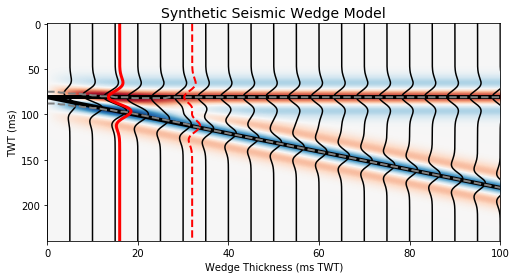

In [380]:
syn_min = synth.min()
syn_max = synth.max()
d_syn = syn_max - syn_min

fig = plt.figure(figsize=(10,4))
ax = fig.add_subplot(111)
for i, trace in enumerate(synth.transpose()[::dx, :]):
    tr = (((trace - syn_min)/d_syn) - 0.5)*1*dx
    x = i*dx
    ax.plot((x + tr), y, 'k')
ax.imshow(synth, cmap='RdBu', aspect=0.2, interpolation='bilinear')
ax.hlines(np.nanargmin(synth[:,-1]), 0, wedge_thickness[-1], linewidth=4)
apparent_top = np.apply_along_axis(np.nanargmin, 0, synth)
apparent_top[0] = apparent_top[1]
ax.plot(wedge_thickness, apparent_top, 'grey', linestyle='--', linewidth=2)
ax.plot([0, wedge_thickness[-1]], [np.nanargmin(synth[:,-1]), np.nanargmax(synth[:, -1])], 'k', linewidth=4)
apparent_base = np.apply_along_axis(np.nanargmax, 0, synth)
apparent_base[0] = apparent_base[1]
ax.plot(wedge_thickness, apparent_base, 'grey', linestyle='--', linewidth=2)
tuning_tr = (((synth[:, int(tuning_twt_meas)] - syn_min)/d_syn) - 0.5)*1*dx
ax.plot((tuning_twt_meas + tuning_tr), y, 'r', linewidth=3)
onset_tr = (((synth[:, int(tuning_twt_onset_meas)] - syn_min)/d_syn) - 0.5)*1*dx
ax.plot((tuning_twt_onset_meas + onset_tr), y, 'r', linestyle='--', linewidth=2)
ax.set_xlabel('Wedge Thickness (ms TWT)')
ax.set_ylabel('TWT (ms)')
ax.set_title('Synthetic Seismic Wedge Model', fontsize=14)
ax.set_xlim(0, wedge_thickness[-1])
#plt.show()
plt.savefig('../pyseistuned/static/img/synthetic_wedge_model_extra.png', dpi=300, edgecolor='k')

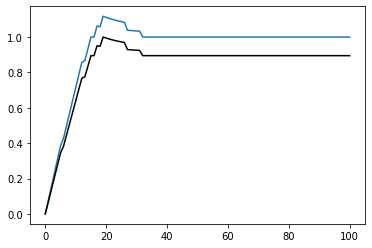

In [383]:
sn2g_uncorr = wedge_thickness / apparent_wedge_thickness
sn2g = (sn2g_uncorr - np.min(sn2g_uncorr)) / (np.max(sn2g_uncorr) - np.min(sn2g_uncorr))
plt.plot(wedge_thickness, sn2g_uncorr)
plt.plot(wedge_thickness, sn2g, 'k')

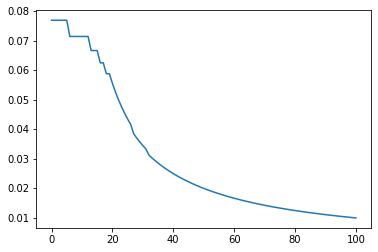

In [381]:
plt.plot(wedge_thickness, 1/apparent_wedge_thickness)

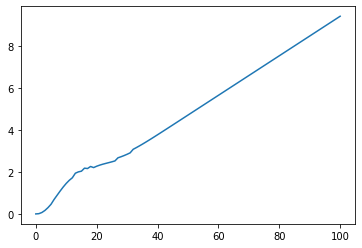

In [387]:
plt.plot(wedge_thickness, amp/(1/apparent_wedge_thickness))

## Spectral Decomposition & Seismic Tuning

In [469]:
lith_trace = np.zeros(950, dtype=np.int64)
#lith_trace[50:59] = 1  # 10 ms
#lith_trace[110:129] = 1  # 20 ms
#lith_trace[180:209] = 1  # 30 ms
#lith_trace[260:299] = 1  # 40 ms
#lith_trace[350:399] = 1  # 50 ms
lith_trace[100:109] = 1  # 10 ms
lith_trace[210:229] = 1  # 20 ms
lith_trace[330:359] = 1  # 30 ms
lith_trace[460:499] = 1  # 40 ms
lith_trace[600:649] = 1  # 50 ms
lith_trace[750:849] = 1  # 100 ms

In [470]:
dt = 0.001
z = np.zeros(lith_trace.shape[0])
z[1:] += dt
z = np.cumsum(z) * 1000

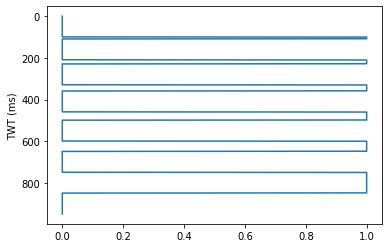

In [471]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(lith_trace, z)
ax.invert_yaxis()
ax.set_ylabel('TWT (ms)')
plt.show()

In [472]:
rocks = np.array(rock_props[:-2]).reshape(2, 2)

In [473]:
earth_trace = rocks[lith_trace]

In [474]:
imp_trace = np.apply_along_axis(np.product, -1, earth_trace)

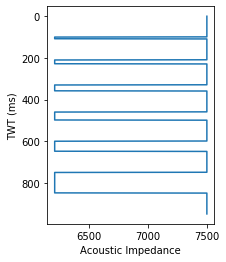

In [475]:
fig = plt.figure(figsize=(3,4))
ax = fig.add_subplot(111)
ax.plot(imp_trace, z)
ax.invert_yaxis()
ax.set_ylabel('TWT (ms)')
ax.set_xlabel('Acoustic Impedance')
plt.show()

In [476]:
rc_trace = np.zeros(imp_trace.shape)
rc_trace[1:] = (imp_trace[1:] - imp_trace[:-1]) / (imp_trace[1:] + imp_trace[:-1])

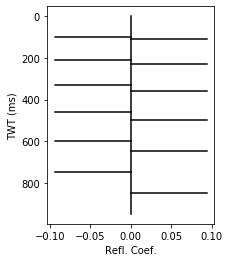

In [477]:
fig = plt.figure(figsize=(3,4))
ax = fig.add_subplot(111)
ax.plot(np.zeros(rc_trace.shape), z, 'k')
for i,_ in enumerate(rc_trace):
    if rc_trace[i] < 0:
        rc_x = [rc_trace[i], 0]
        rc_y = [i, i]
        ax.plot(rc_x, rc_y, 'k')
    elif rc_trace[i] > 0:
        rc_x = [0, rc_trace[i]]
        rc_y = [i, i]
        ax.plot(rc_x, rc_y, 'k')
ax.invert_yaxis()
ax.set_ylabel('TWT (ms)')
ax.set_xlabel('Refl. Coef.')
plt.show()

In [478]:
ricker_05 = wavelet(duration=0.4, dt=0.001, w_type=0, f=[5])
ricker_10 = wavelet(duration=0.2, dt=0.001, w_type=0, f=[10])
ricker_15 = wavelet(duration=0.2, dt=0.001, w_type=0, f=[15])
ricker_20 = wavelet(duration=0.1, dt=0.001, w_type=0, f=[20])
ricker_25 = wavelet(duration=0.1, dt=0.001, w_type=0, f=[25])
ricker_30 = wavelet(duration=0.1, dt=0.001, w_type=0, f=[30])
ricker_35 = wavelet(duration=0.1, dt=0.001, w_type=0, f=[35])
ricker_40 = wavelet(duration=0.1, dt=0.001, w_type=0, f=[40])
ricker_45 = wavelet(duration=0.1, dt=0.001, w_type=0, f=[45])
ricker_50 = wavelet(duration=0.1, dt=0.001, w_type=0, f=[50])
ricker_55 = wavelet(duration=0.1, dt=0.001, w_type=0, f=[55])
ricker_60 = wavelet(duration=0.1, dt=0.001, w_type=0, f=[60])

In [479]:
def convolve(rc, wavelet):
    synth = np.apply_along_axis(lambda t: np.convolve(t, wavelet, mode="same"), axis=0, arr=rc)
    return synth

In [480]:
synth_05 = convolve(rc_trace, ricker_05)
synth_10 = convolve(rc_trace, ricker_10)
synth_15 = convolve(rc_trace, ricker_15)
synth_20 = convolve(rc_trace, ricker_20)
synth_25 = convolve(rc_trace, ricker_25)
synth_30 = convolve(rc_trace, ricker_30)
synth_35 = convolve(rc_trace, ricker_35)
synth_40 = convolve(rc_trace, ricker_40)
synth_45 = convolve(rc_trace, ricker_45)
synth_50 = convolve(rc_trace, ricker_50)
synth_55 = convolve(rc_trace, ricker_55)
synth_60 = convolve(rc_trace, ricker_60)

In [481]:
iso_freq_gather = np.column_stack((synth_05, synth_10, synth_15, synth_20, synth_25, synth_30, synth_35, synth_40, synth_45, synth_50, synth_55, synth_60))

In [495]:
iso_freq_gather.shape

(950, 12)

In [502]:
np.argmin(iso_freq_gather[:,5])

99

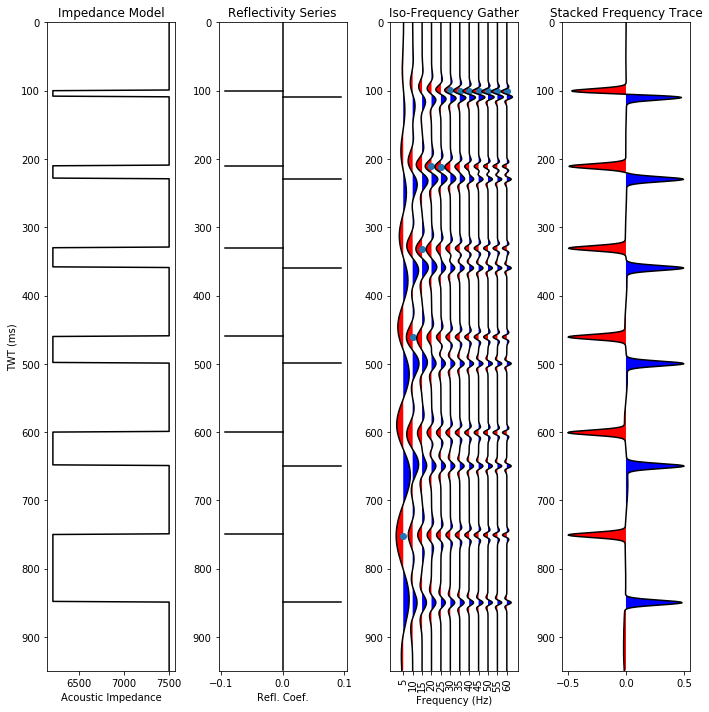

In [543]:
ifg_min = np.min(iso_freq_gather)
ifg_max = np.max(iso_freq_gather)
d_ifg = ifg_max - ifg_min

dx = 5

fig = plt.figure(figsize=(10,10))

ax1 = fig.add_subplot(141)
ax1.plot(imp_trace, z, 'k')
ax1.set_xlabel('Acoustic Impedance')
ax1.set_ylabel('TWT (ms)')
ax1.set_title('Impedance Model')
ax1.set_yticks(range(0,1000,100))
ax1.set_ylim(0,950)
ax1.invert_yaxis()

ax2 = fig.add_subplot(142, sharey=ax1)
ax2.plot(np.zeros(rc_trace.shape), z, 'k')
for i,_ in enumerate(rc_trace):
    if rc_trace[i] < 0:
        rc_x = [rc_trace[i], 0]
        rc_y = [i, i]
        ax2.plot(rc_x, rc_y, 'k')
    elif rc_trace[i] > 0:
        rc_x = [0, rc_trace[i]]
        rc_y = [i, i]
        ax2.plot(rc_x, rc_y, 'k')
ax2.set_xlabel('Refl. Coef.')
ax2.set_title('Reflectivity Series')

ax3 = fig.add_subplot(143, sharey=ax1)
for i, trace in enumerate(iso_freq_gather.transpose()):
    tr = (((trace - ifg_min)/d_ifg) - 0.5)*dx*1.5
    x = i*dx + 5
    ax3.plot((x + tr), z, 'k')
    ax3.fill_betweenx(z, x, (x + tr), where=tr>=0, facecolor='blue')
    ax3.fill_betweenx(z, x, (x + tr), where=tr<=0, facecolor='red')
ax3.scatter(range(5,65,5), np.argmin(iso_freq_gather, axis=0))
ax3.set_xlabel('Frequency (Hz)')
ax3.set_xticks(range(5,65,5))
ax3.xaxis.set_tick_params(rotation=90)
ax3.set_title('Iso-Frequency Gather')

ax4 = fig.add_subplot(144, sharey=ax1)
summed_tr = np.apply_along_axis(np.sum, -1, iso_freq_gather)
summed_tr = (((summed_tr - np.min(summed_tr))/(np.max(summed_tr) - np.min(summed_tr))) - 0.5)
ax4.plot(summed_tr, z, 'k')
ax4.fill_betweenx(z, 0, summed_tr, where=summed_tr>0, facecolor='blue')
ax4.fill_betweenx(z, 0, summed_tr, where=summed_tr<0, facecolor='red')
ax4.set_title('Stacked Frequency Trace')

plt.tight_layout()

In [521]:
np.argmin(iso_freq_gather[550:650,:], axis=0) + 550

array([589, 603, 601, 601, 601, 601, 601, 601, 601, 601, 601, 601])

In [526]:
np.amin(iso_freq_gather[550:650,:], axis=0)

array([-0.14126514, -0.12861666, -0.09858851, -0.09422141, -0.0940929 ,
       -0.09409191, -0.0940919 , -0.0940919 , -0.0940919 , -0.0940919 ,
       -0.0940919 , -0.0940919 ])

In [525]:
np.where(iso_freq_gather == np.amin(iso_freq_gather, axis=0))

(array([ 99, 100, 101, 101, 101, 101, 101, 211, 212, 332, 461, 752]),
 array([ 5,  6,  7,  8,  9, 10, 11,  3,  4,  2,  1,  0]))